## Loading the Keras package
We begin by loading keras and the other packages

In [110]:
import keras

In [111]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing, svm, linear_model
%matplotlib inline

In [112]:
#Define a function to return the path of csv
def symbol_to_path(symbol, base_dir="NASDAQ"):
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))
#Define a function to get DataFrame 'Adj Close'
def get_data(symbol):
    df = pd.read_csv(symbol_to_path(symbol), usecols=['Adj Close'])
    data0 = np.array(df)
    if len(data0 == 188):
        data1 = data0
    return data1
def get_pre(symbol):
    df = pd.read_csv(symbol_to_path(symbol), usecols=['Open', 'High', 'Low'])
    return df

In [113]:
symbols = ['AAPL', 'GOOG', 'TSLA', 'TURN', 'FLWS']
def get_stock(symbols, dates):
    df=pd.DataFrame(index=dates)
    df_temp = pd.read_csv('SPY.csv', index_col = 'Date', parse_dates = True, usecols=['Date','Adj Close'], na_values=['nan'])
    df_temp = df_temp.rename(columns = {'Adj Close':'SPY'})
    df = df.join(df_temp)
    df = df.dropna(subset=["SPY"])
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col = 'Date', parse_dates = True, usecols=['Date','Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns = {'Adj Close':symbol})
        df = df.join(df_temp)
    return df

def plot_data(df, title = "Stock price"):
    ax = df.plot(title = title, fontsize = 10, grid = True)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()
    
def normalize_data(df):
    df = df/df.iloc[0,:]
    return df
    
def plot_stock():
    start_date='2017-01-01'
    end_date='2017-9-29'
    dates=pd.date_range(start_date,end_date)
    df = get_stock(symbols, dates)
    df = normalize_data(df)
    plot_data(df)

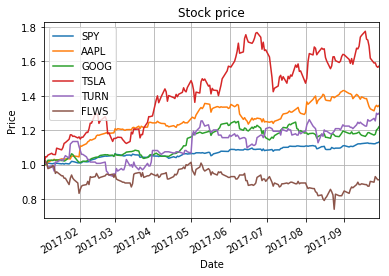

In [114]:
plot_stock()

for future use, we read stock data from folder 'NASDAQ'. Because we only predict the adjust close price of the stock, we only use this line of each stock.

In [115]:
import glob
path_lst=glob.glob(r'NASDAQ/*.csv')

In [116]:
stocks = []
for path in path_lst:
    df = pd.read_csv(path)
    df = df.fillna(method='ffill')
    stk = np.array(df['Adj Close'])
    stk = stk[np.logical_not(np.isnan(stk))]
    #stk_preprocessing = preprocessing.scale(stk)
    if(len(stk)==188):
        stocks.append(stk)

print several stock prices in figure.

slice the stock data into a 30 day circle. For each slice, first 29 days' price is considered to be the input while the 30th day's price is considered to be the output. Remember, the last day of the data should not be involved, because it is considered to be 'future'!

In [117]:
'''
slice_len = 30 ## pretend we have all stock data except the last day.
stocks_sliced = []
for i in range(len(stocks)):
    pointer = 0
    stk = stocks[i]
    while(pointer + slice_len < len(stk)):
        stocks_sliced.append(stk[pointer:pointer+slice_len])
        pointer = pointer+slice_len
stocks_sliced = np.array(stocks_sliced)
print(np.shape(stocks_sliced)) 
'''
stocks_sliced = []
for i in range(len(stocks)):
    pointer = 0
    stk = stocks[i]
    while(pointer + 30 < len(stk)):
        stocks_sliced.append(stk[pointer:pointer+30])
        pointer = pointer+30
stocks_sliced = np.array(stocks_sliced)   

In [118]:
X_tr = stocks_sliced[:,0:29]
lastday = stocks_sliced[:,29]
day_before_lastday = stocks_sliced[:,28]
y_tr = np.array([])
for i in range(len(lastday)):
    if(lastday[i]>day_before_lastday[i]):
        y_tr = np.append(y_tr,[1])
    else:
        y_tr = np.append(y_tr,[0])
X_tr = np.array(X_tr)
X_tr = preprocessing.scale(X_tr)

In [119]:
import random
X_ts_pre = random.sample(stocks, 2000)
X_ts = []
y_ts = np.array([])
k = 0
for i in X_ts_pre:
    if len(i) > 29:
        X_ts.append(i[len(i)-30:len(i)-1])
        if i[len(i)-1]>i[len(i)-2]:
            y_ts = np.append(y_ts,[1])
        else:
            y_ts = np.append(y_ts,[0])
X_ts = np.array(X_ts)
X_ts = preprocessing.scale(X_ts)

In [120]:
# logistic regression
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_tr, y_tr)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [121]:
y_ts_pred = logreg.predict(X_ts)
acc = np.mean(y_ts == y_ts_pred)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 0.533000


In [122]:
X_tr_svm = stocks_sliced[:,0:29]
lastday = stocks_sliced[:,29]
day_before_lastday = stocks_sliced[:,28]
y_tr_svm = np.array([])
for i in range(len(lastday)):
    if(lastday[i]>day_before_lastday[i]):
        y_tr_svm = np.append(y_tr_svm,[1])
    else:
        y_tr_svm = np.append(y_tr_svm,[-1]) 
X_tr_svm = np.array(X_tr_svm)

In [123]:
import random
X_ts_pre = random.sample(stocks, 2000)
X_ts_svm = []
y_ts_svm = np.array([])
k = 0
for i in X_ts_pre:
    if len(i) > 29:
        X_ts_svm.append(i[len(i)-30:len(i)-1])
        if i[len(i)-1]>i[len(i)-2]:
            y_ts_svm = np.append(y_ts_svm,[1])
        else:
            y_ts_svm = np.append(y_ts_svm,[-1])
X_ts_svm = np.array(X_ts_svm)
print(X_ts_svm.shape)

(2000, 29)


In [124]:
stocks_sliced = []
for i in range(len(stocks)):
    pointer = 0
    stk = stocks[i]
    while(pointer + 30 < len(stk)):
        stocks_sliced.append(stk[pointer:pointer+30])
        pointer = pointer+30
stocks_sliced = np.array(stocks_sliced)

In [156]:
#10-day momentum
def momentum(stocks_sliced):
    mt = []
    for i in range(20):
        mt.append(stocks_sliced[:,i+10]/stocks_sliced[:,i]-1)
    mt = np.array(mt).T
    mt = np.mean(mt, axis=1)[:,None]
    return mt

In [157]:
#10-day simple moving average
def sma(stocks_sliced):
    mean = []
    for i in range(20):
        mean.append(np.mean(stocks_sliced[:,i:i+10], axis=1))
    mean = np.array(mean).T
    sma1 = (mean/stocks_sliced[:,0:20])-1
    sma = np.mean(sma1, axis=1)[:,None]
    return sma
def sma1(stocks_sliced):
    mean = []
    for i in range(20):
        mean.append(np.mean(stocks_sliced[:,i:i+10], axis=1))
    mean = np.array(mean).T
    sma1 = (mean/stocks_sliced[:,0:20])-1
    return sma1[:,0:20]

In [158]:
#bollinger brands
def bb(stocks_sliced):
    std = []
    for i in range(20):
        std.append(np.std(stocks_sliced[:,i:i+10], axis=1))
    std = np.array(std).T
    bb = (stocks_sliced[:,0:20]-sma1(stocks_sliced))/2*std-1
    bb = np.mean(bb, axis=1)[:,None]
    return bb

In [159]:
mt = momentum(stocks_sliced)
sma = sma(stocks_sliced)
bb = bb(stocks_sliced)
Xtr = np.column_stack((mt,sma,bb))

In [160]:
ntr = 15000
nts = Xtr.shape[0]-ntr
X_tr = Xtr[:ntr,:]
ytr = y_tr_svm[:ntr]
X_ts = Xtr[ntr:ntr+nts,:]
yts = y_tr_svm[ntr:ntr+nts]

(2466, 3)


In [162]:
svc = svm.SVC(probability=False,kernel="rbf",C=2.8,gamma=.0073,verbose=10)
svc.fit(X_tr,ytr)

[LibSVM]

SVC(C=2.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0073, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=10)

In [164]:
yhat_ts = svc.predict(X_ts)
acc = np.mean(yhat_ts == yts)
print('Accuaracy = {0:f}'.format(acc))

Accuaracy = 0.527170


In [12]:
X_tr = stocks_sliced[:,0:slice_len -1]
lastday = stocks_sliced[:,slice_len -1]
day_before_lastday = stocks_sliced[:,slice_len -2]
y_tr = np.array([])
for i in range(len(lastday)):
    if(lastday[i]>day_before_lastday[i]):
        y_tr = np.append(y_tr,[1])
    else:
        y_tr = np.append(y_tr,[0])
X_tr = np.array(X_tr)

In [13]:
import random
X_ts_pre = random.sample(stocks, 200)
X_ts = []
y_ts = np.array([])
k = 0
for i in X_ts_pre:
    if len(i) > slice_len -1:
        X_ts.append(i[len(i)-slice_len:len(i)-1])
        if i[len(i)-1]>i[len(i)-2]:
            y_ts = np.append(y_ts,[1])
        else:
            y_ts = np.append(y_ts,[0])
X_ts = np.array(X_ts)

In [14]:
X_ts = np.expand_dims(X_ts, axis=2)
X_tr = np.expand_dims(X_tr, axis=2)

then, we clear the backend of keras

In [205]:
import keras.backend as K
K.clear_session()

input subpackets

In [206]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation
from keras.layers import Conv1D, Flatten, Dropout
model = Sequential()
model.add(Conv1D(input_shape = (slice_len -1,1),filters = 4,kernel_size=5,activation='relu',name = 'conv1D1'))
model.add(Conv1D(filters = 2,kernel_size=3,activation='relu',name = 'conv1D2'))
model.add(Flatten())
model.add(Dense(60, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', name='output'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1D1 (Conv1D)             (None, 182, 4)            24        
_________________________________________________________________
conv1D2 (Conv1D)             (None, 180, 2)            26        
_________________________________________________________________
flatten_1 (Flatten)          (None, 360)               0         
_________________________________________________________________
hidden (Dense)               (None, 60)                21660     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 61        
Total params: 21,771
Trainable params: 21,771
Non-trainable params: 0
_________________________________________________________________


In [207]:
from keras import optimizers
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [208]:
model.fit(X_tr, y_tr, epochs=20, batch_size=100, validation_data=(X_ts,y_ts))

Train on 2911 samples, validate on 200 samples
Epoch 1/20
2911/2911 [==============================] - 0s - loss: 0.7445 - acc: 0.5002 - val_loss: 0.6958 - val_acc: 0.5050
Epoch 2/20
2911/2911 [==============================] - 0s - loss: 0.7217 - acc: 0.5191 - val_loss: 0.6972 - val_acc: 0.5300
Epoch 3/20
2911/2911 [==============================] - 0s - loss: 0.6963 - acc: 0.5407 - val_loss: 0.7008 - val_acc: 0.5500
Epoch 4/20
2911/2911 [==============================] - 0s - loss: 0.6931 - acc: 0.5335 - val_loss: 0.7001 - val_acc: 0.5100
Epoch 5/20
2911/2911 [==============================] - 0s - loss: 0.6821 - acc: 0.5589 - val_loss: 0.7045 - val_acc: 0.5250
Epoch 6/20
2911/2911 [==============================] - 0s - loss: 0.6771 - acc: 0.5575 - val_loss: 0.7057 - val_acc: 0.5050
Epoch 7/20
2911/2911 [==============================] - 0s - loss: 0.6750 - acc: 0.5654 - val_loss: 0.7143 - val_acc: 0.4750
Epoch 8/20
2911/2911 [==============================] - 0s - loss: 0.6720 - ac

ranking part

In [218]:
y_ranking_tr = lastday/day_before_lastday


import random
X_ranking_ts_pre = random.sample(stocks, 200)
X_ranking_ts = []
y_ranking_ts = np.array([])
k = 0
for i in X_ranking_ts_pre:
    if len(i) > slice_len -1:
        X_ranking_ts.append(i[len(i)-slice_len:len(i)-1])
        y_ranking_ts = np.append(y_ranking_ts,i[len(i)-1]/i[len(i)-2])
X_ranking_ts = np.array(X_ranking_ts)


In [219]:
X_ranking_ts = np.expand_dims(X_ranking_ts, axis=2)
# X_tr = np.expand_dims(X_tr, axis=2)

In [233]:
print(X_ranking_ts[1])

[[ 1.18893336]
 [ 0.99485101]
 [ 0.99485101]
 [ 0.86546277]
 [ 1.44770983]
 [ 1.05954512]
 [ 0.99485101]
 [ 0.99485101]
 [ 0.80076865]
 [ 1.05954512]
 [ 0.86546277]
 [ 0.73607453]
 [ 0.47729806]
 [ 0.80076865]
 [ 0.73607453]
 [ 0.54199218]
 [ 0.67138042]
 [ 0.6066863 ]
 [ 0.54199218]
 [ 0.47729806]
 [ 0.67138042]
 [ 0.80076865]
 [ 0.54199218]
 [ 0.80076865]
 [ 0.86546277]
 [ 1.25362748]
 [ 1.51240395]
 [ 0.86546277]
 [ 0.99485101]
 [ 1.12423924]
 [ 1.12423924]
 [ 0.93015689]
 [ 0.86546277]
 [ 0.86546277]
 [ 0.86546277]
 [ 0.73607453]
 [ 0.93015689]
 [ 0.6066863 ]
 [ 0.80076865]
 [ 0.67138042]
 [ 0.67138042]
 [ 0.6066863 ]
 [ 0.47729806]
 [ 0.47729806]
 [ 0.47729806]
 [ 0.41260394]
 [ 0.80076865]
 [ 1.05954512]
 [ 0.80076865]
 [ 0.93015689]
 [ 0.80076865]
 [ 0.67138042]
 [ 0.86546277]
 [ 0.80076865]
 [ 0.86546277]
 [ 1.05954512]
 [ 1.44770983]
 [ 1.18893336]
 [ 1.3183216 ]
 [ 1.12423924]
 [ 1.25362748]
 [ 1.12423924]
 [ 1.18893336]
 [ 1.12423924]
 [ 0.73607453]
 [ 0.80076865]
 [ 1.05954

In [210]:
K.clear_session()

In [220]:
model_r = Sequential()
model_r.add(Conv1D(input_shape = (slice_len -1,1),filters = 4,kernel_size=5,activation='relu',name = 'conv1D1'))
model_r.add(Conv1D(filters = 2,kernel_size=3,activation='relu',name = 'conv1D2'))
model_r.add(Flatten())
model_r.add(Dense(60, input_shape=(nin,), activation='sigmoid', name='hidden'))
model_r.add(Dropout(0.5))
model_r.add(Dense(1, activation='linear', name='output'))
model_r.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1D1 (Conv1D)             (None, 182, 4)            24        
_________________________________________________________________
conv1D2 (Conv1D)             (None, 180, 2)            26        
_________________________________________________________________
flatten_2 (Flatten)          (None, 360)               0         
_________________________________________________________________
hidden (Dense)               (None, 60)                21660     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 61        
Total params: 21,771
Trainable params: 21,771
Non-trainable params: 0
_________________________________________________________________


In [226]:
opt_r = optimizers.Adam(lr=0.001)
model_r.compile(optimizer=opt_r,
              loss='mean_squared_error')

In [227]:
model_r.fit(X_tr, y_ranking_tr, epochs=10, batch_size=100, validation_data=(X_ranking_ts,y_ranking_ts))

Train on 2911 samples, validate on 200 samples
Epoch 1/10
2911/2911 [==============================] - 0s - loss: 15.2629 - val_loss: 4.3344
Epoch 2/10
2911/2911 [==============================] - 0s - loss: 15.1241 - val_loss: 4.2732
Epoch 3/10
2911/2911 [==============================] - 0s - loss: 15.2994 - val_loss: 4.3203
Epoch 4/10
2911/2911 [==============================] - 0s - loss: 15.3500 - val_loss: 4.3218
Epoch 5/10
2911/2911 [==============================] - 0s - loss: 15.3498 - val_loss: 4.3330
Epoch 6/10
2911/2911 [==============================] - 0s - loss: 15.1777 - val_loss: 4.3666
Epoch 7/10
2911/2911 [==============================] - 0s - loss: 15.2919 - val_loss: 4.2962
Epoch 8/10
2911/2911 [==============================] - 0s - loss: 15.1247 - val_loss: 4.3282
Epoch 9/10
2911/2911 [==============================] - 0s - loss: 15.0422 - val_loss: 4.3600
Epoch 10/10
2911/2911 [==============================] - 0s - loss: 14.9919 - val_loss: 4.3034
